<center>
<img
     src="./data/logo.png"
     alt="logo_lapage"
     WIDTH= 550px
     padding= 7px>
    </center><br>

<h1  style= "background-color: gray;
                 color:white;
            text-align: center; 
            font-family:Helvetica, Arial, verdana, sans-serif"> Clustering </h1>
<br>

In [1]:
import pandas as pd
import numpy as np
from functions import *
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## 1. Contexte

Dans la partie précédente nous avons déterminé 6 indicateurs pour la stratégie de ciblage des pays. Nous avons rassemblé et préparé les données de 177 pays.

Plan d'action :

1. Réaliser une ACP afin de visualiser et d'édutier les corrélations entre nos indicateurs
2. Réaliser un clustering CAH puis un Kmeans
3. Comparer les deux méthodes






In [2]:
data = pd.read_csv("./data/df.csv",index_col="Area")
data.head()

,Import Quantity,GDP growth per capita (US$),GDP per capita (US$),Avg. population growth (annual %),Political_Stability,Region,Union european
Area,,,,,,,
Afghanistan,44.0,0.289848,496.940553,2.87,-2.75,Asia,0
Albania,22.0,1.672835,5345.602513,-0.15,0.38,Europe,0
Algeria,0.0,-4.295718,3975.519002,2.06,-0.79,Africa,0
Angola,278.0,-14.591763,2809.626403,3.44,-0.32,Africa,0
Antigua and Barbuda,7.0,4.180217,17376.112907,1.02,0.73,Americas,0


In [3]:
# On exclut le ranking Top conso
X = data.drop(["Region", "Union european"], axis=1)

## 2. Pre-processing

### 2.1. Détection d'anomalie

In [4]:
from sklearn.ensemble import IsolationForest
model = IsolationForest(n_estimators=200, contamination=0.02, random_state=42)
model.fit(X)
outliers = model.predict(X) == -1 
out = data[outliers]
out

,Import Quantity,GDP growth per capita (US$),GDP per capita (US$),Avg. population growth (annual %),Political_Stability,Region,Union european
Area,,,,,,,
Japan,1094.0,2.496903,40586.234684,-0.17,1.06,Asia,0
Luxembourg,12.0,-3.364702,114004.238058,2.18,1.37,Europe,1
Mexico,1033.0,2.679234,9946.016618,1.21,-0.57,Americas,0
Syrian Arab Republic,23.0,19.505591,1558.084651,-2.85,-2.74,Asia,0


In [5]:
# On met de coté les outliers
data = data[~data.index.isin(X[outliers].index.tolist())]
X = X[~X.index.isin(X[outliers].index.tolist())]

<div class="alert-warning">
    <b>Attention :</b> On met de coté les outliers!
</div>
<br>

### 2.2. Standardisation des données

In [6]:
# Import the sklearn function
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check
pd.DataFrame(X_scaled, columns=X.columns).describe().round(2)

,Import Quantity,GDP growth per capita (US$),GDP per capita (US$),Avg. population growth (annual %),Political_Stability
count,173.00,173.00,173.00,173.00,173.00
mean,0.00,-0.00,0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00
min,-0.50,-4.21,-0.71,-2.35,-3.14
25%,-0.48,-0.42,-0.63,-0.72,-0.61
50%,-0.38,0.01,-0.41,-0.15,0.11
75%,0.04,0.45,0.15,0.79,0.83
max,4.76,3.79,3.74,3.21,1.80


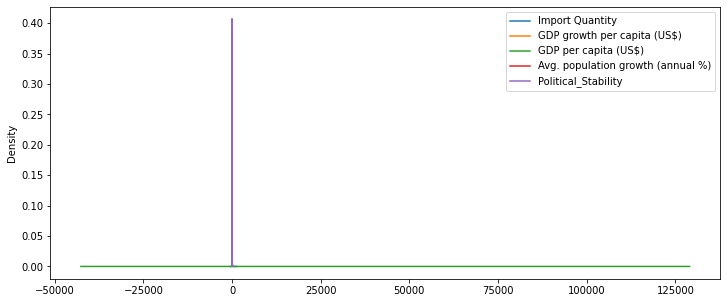

In [7]:
# Before standardisation
X1 = pd.DataFrame(X,columns=X.columns)
X1.plot(kind='density',sharex=True,figsize=(12,5),layout=(10,1))
plt.show()

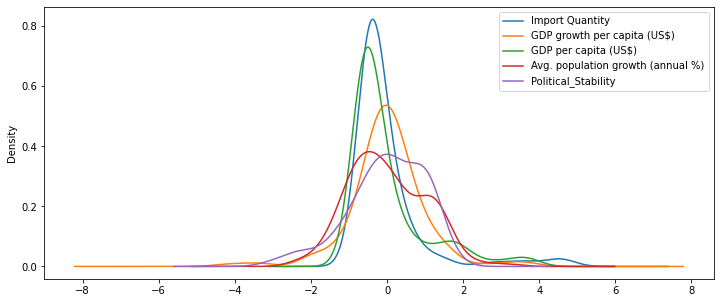

In [8]:
# After standardisation
pd.DataFrame(X_scaled,columns=X.columns).plot(kind='density',sharex=True,figsize=(12,5),layout=(10,1))
plt.show()

In [9]:
pd.DataFrame(X_scaled, index=X.index,columns=X.columns).head()

,Import Quantity,GDP growth per capita (US$),GDP per capita (US$),Avg. population growth (annual %),Political_Stability
Area,,,,,
Afghanistan,-0.222486,0.023886,-0.699567,1.301822,-2.867402
Albania,-0.361714,0.220215,-0.448113,-1.268467,0.536455
Algeria,-0.500942,-0.627082,-0.519166,0.612440,-0.735913
Angola,1.258390,-2.088712,-0.579630,1.786943,-0.224791
Antigua and Barbuda,-0.456642,0.576164,0.175795,-0.272693,0.917078


## 3. ACP

In [10]:
# Import the PCA function from sklearn
from sklearn.decomposition import PCA

# Create the PCA model
model_pca = PCA()

# Fit the model with the standardised data
X_reduced = model_pca.fit_transform(X_scaled)

In [11]:
# Explained variance ratio
model_pca.explained_variance_ratio_.round(2)

array([0.4 , 0.22, 0.18, 0.13, 0.08])

In [12]:
# Explained variance ratio cumsum
model_pca.explained_variance_ratio_.cumsum().round(2)

array([0.4 , 0.61, 0.79, 0.92, 1.  ])

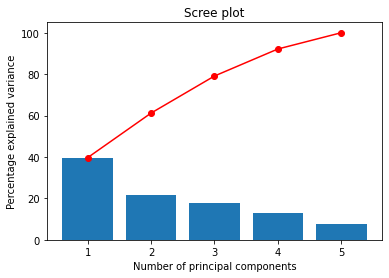

In [13]:
# Scree plot
display_scree_plot(model_pca) 


<div class="alert-info">
    <p><strong> On recupère 92% d'inertie à partir de la 4e composante </strong>.</p>
</div>
<br>

In [14]:
# Nombre de composantes à étudier
num_components = 5
pcs = model_pca.components_ 
pc1 = model_pca.components_[0]
pc2 = model_pca.components_[1]
pc3 = model_pca.components_[2]
pc4 = model_pca.components_[3]
pc5 = model_pca.components_[4]

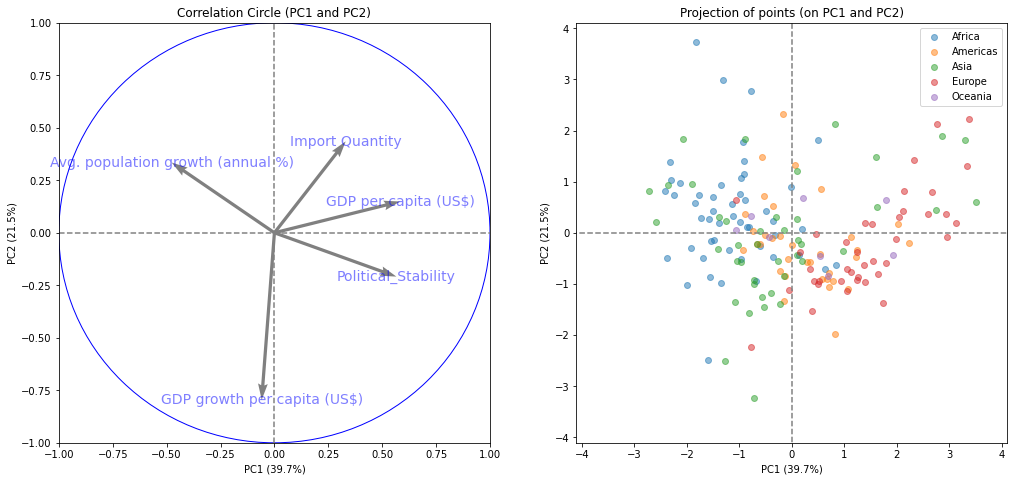

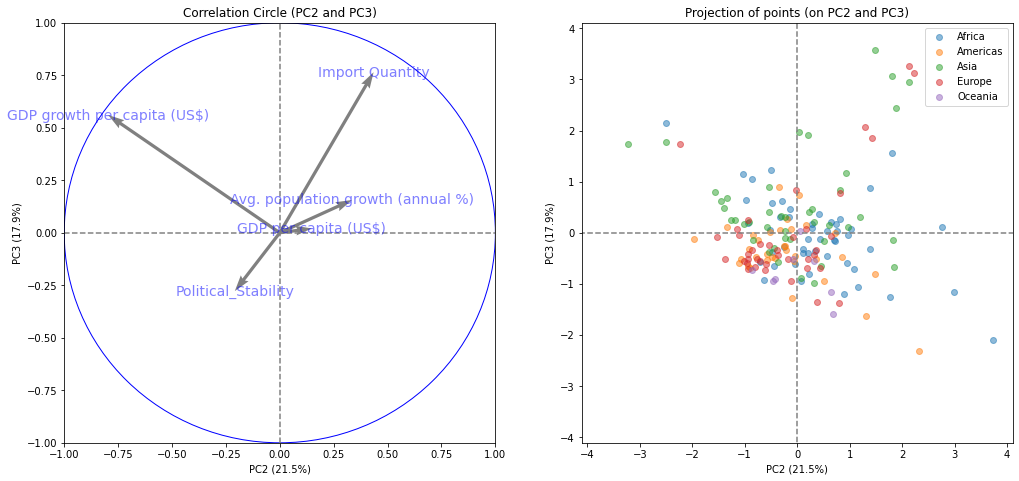

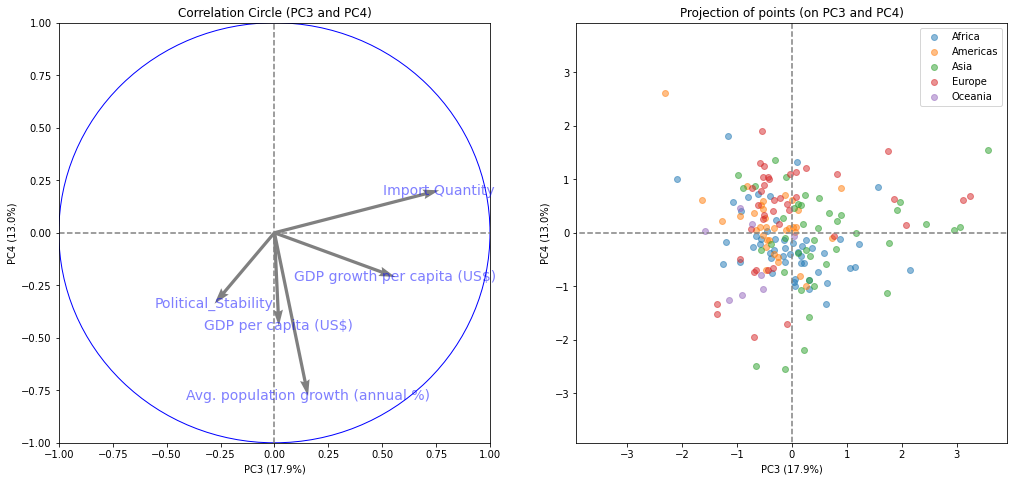

In [15]:
# Take a copy of the data an add a new column for the banding (top import)
classed_data = data.copy()
#append_class(classed_data, 'rank_band','Top Consumption',[0,11,101,180],['Top 10','Top 100','Top 180'])

# Get a list of the new bandings that we can pass to the plot
#classed_data = classed_data.reset_index()
rank_band = [classed_data.loc[country_id, "Region"] for country_id in classed_data.index]

X_projected = model_pca.transform(X_scaled)

plt.figure(figsize=(17,17))
plt.subplot(2,2,1)
display_circles(pcs, num_components, model_pca, [(0,1)], labels = np.array(X.columns))
plt.subplot(2,2,2)
display_factorial_planes(X_projected, num_components, model_pca, [(0,1)], illustrative_var = rank_band, alpha = 0.5)
plt.show()

print("="*100,"\n")
plt.figure(figsize=(17,17))
plt.subplot(2,2,1)
display_circles(pcs, num_components, model_pca, [(1,2)], labels = np.array(X.columns))
plt.subplot(2,2,2)
display_factorial_planes(X_projected, num_components, model_pca, [(1,2)], illustrative_var = rank_band, alpha = 0.5)
plt.show()

print("="*100,"\n")
plt.figure(figsize=(17,17))
plt.subplot(2,2,1)
display_circles(pcs, num_components, model_pca, [(2,3)], labels = np.array(X.columns))
plt.subplot(2,2,2)
display_factorial_planes(X_projected, num_components, model_pca, [(2,3)], illustrative_var = rank_band, alpha = 0.5)
plt.show()

In [16]:
coords = pd.DataFrame(X_projected, index=X.index, columns=['PC1','PC2','PC3','PC4','PC5'])

### Matrices des corrélations

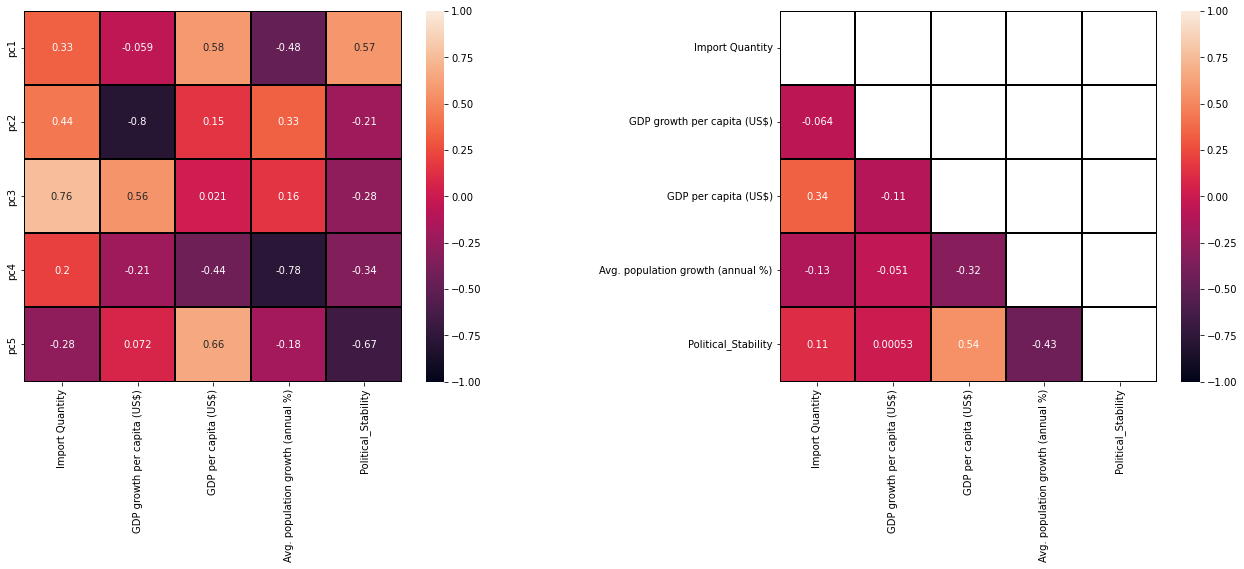

In [17]:
pcs2 = pd.DataFrame(pcs, columns=['Import Quantity', 'GDP growth per capita (US$)',
       'GDP per capita (US$)', 'Avg. population growth (annual %)',
       'Political_Stability'])
pcs2.index = ["pc1","pc2","pc3","pc4","pc5"]

plt.figure(figsize=(22,15))
plt.subplot(2,2,1)
sns.heatmap(pcs2, annot=True,linecolor='k', linewidths=2,vmin=-1, vmax=1,)
plt.subplot(2,2,2)
mask = np.triu(np.ones_like(X.corr(), dtype=bool))
sns.heatmap(X.corr(), mask=mask, vmin=-1, vmax=1, annot=True,linecolor='k', linewidths=2)
plt.subplots_adjust(wspace=0.6)
plt.show()

<div>
    <p><strong> PC1 :</strong> représente le pays plûtot stable à PIB plûtot élévé et une faible croissance démographique.</p>
    <p><strong> PC2 :</strong> Importations de vollaile plûtot moyennes et mauvaise croissance économique.</p>  
    <p><strong> PC3 :</strong> Importantes importations de vollaile et plûtot bonne croissance économique.</p>
    <p><strong> PC4 :</strong> Mauvaise croissance démographique et PIB bas </p>
</div>
<br>

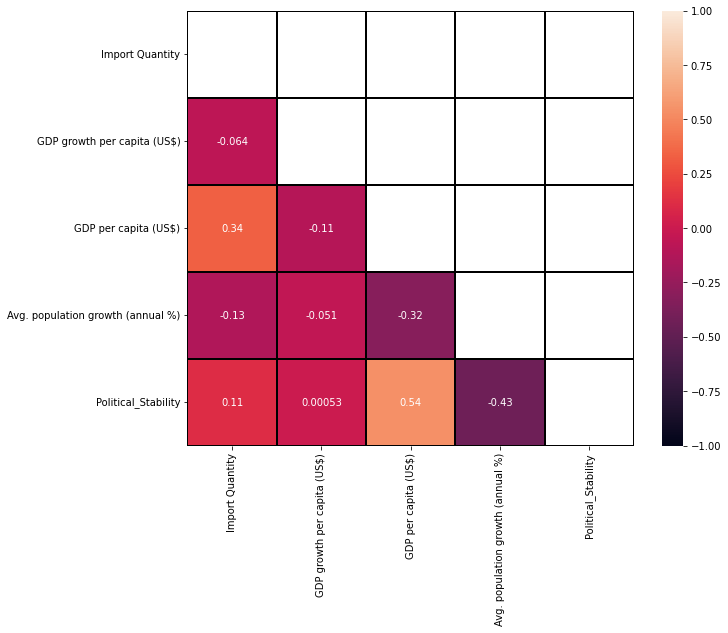

In [18]:
plt.figure(figsize=(10,8))
mask = np.triu(np.ones_like(X.corr(), dtype=bool))
sns.heatmap(X.corr(), mask=mask, vmin=-1, vmax=1, annot=True,linecolor='k', linewidths=2)
plt.show()

## 4. Clustering

### 4.1. Recherche du nombre optimal de cluster pour la classification

#### 4.1.1. Elbow method

In [19]:
!pip install yellowbrick

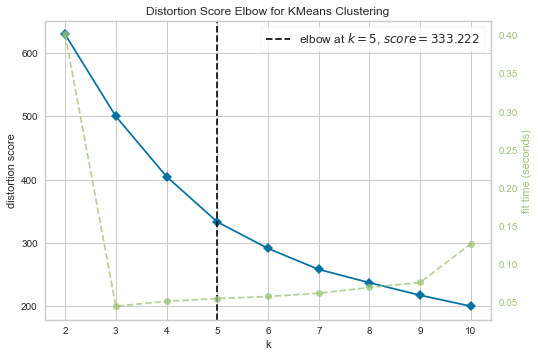

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [20]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
model = KElbowVisualizer(KMeans(), k=10)
model.fit(X_scaled)
model.show()


<div class="alert-info">
    <p><strong> Selon la courbe d'elbow, le nombre optimal de cluster 5 </strong></p>
</div>
<br>

#### 4.1.2. Silhouette score

In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
range_n_clusters = list (range(2,10))
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, preds)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.2814443273830444)
For n_clusters = 3, silhouette score is 0.26312456510587834)
For n_clusters = 4, silhouette score is 0.2838115177422764)
For n_clusters = 5, silhouette score is 0.2764858665048969)
For n_clusters = 6, silhouette score is 0.2892524383801043)
For n_clusters = 7, silhouette score is 0.2832319422273317)
For n_clusters = 8, silhouette score is 0.27516899710776915)
For n_clusters = 9, silhouette score is 0.24824797008473531)



<div class="alert-info">
    <p><strong> Selon le score de silhouhette, le nombre optimal de cluster est soit 6, suivi de 5 </strong></p>
</div>
<br>

### 4.2. Classification Ascendante Hiérarchique (CAH)

In [22]:
# Import the hierarchical clustering algorithm
from sklearn.cluster import AgglomerativeClustering

# Create a hierarchical clustering model
hiercluster = AgglomerativeClustering(affinity='euclidean', linkage='ward', compute_full_tree=True) 

# Fit the data to the model and determine which clusters each data point belongs to:
hiercluster.set_params(n_clusters=5)
clusters = hiercluster.fit_predict(X_scaled) 
np.bincount(clusters) # count of data points in each cluster



array([58, 34, 53,  9, 19], dtype=int64)

In [23]:
# Add the cluster number to the original scaled data
X_clustered = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X_clustered["cluster"] = clusters

#### 4.2.1. Dendogramme

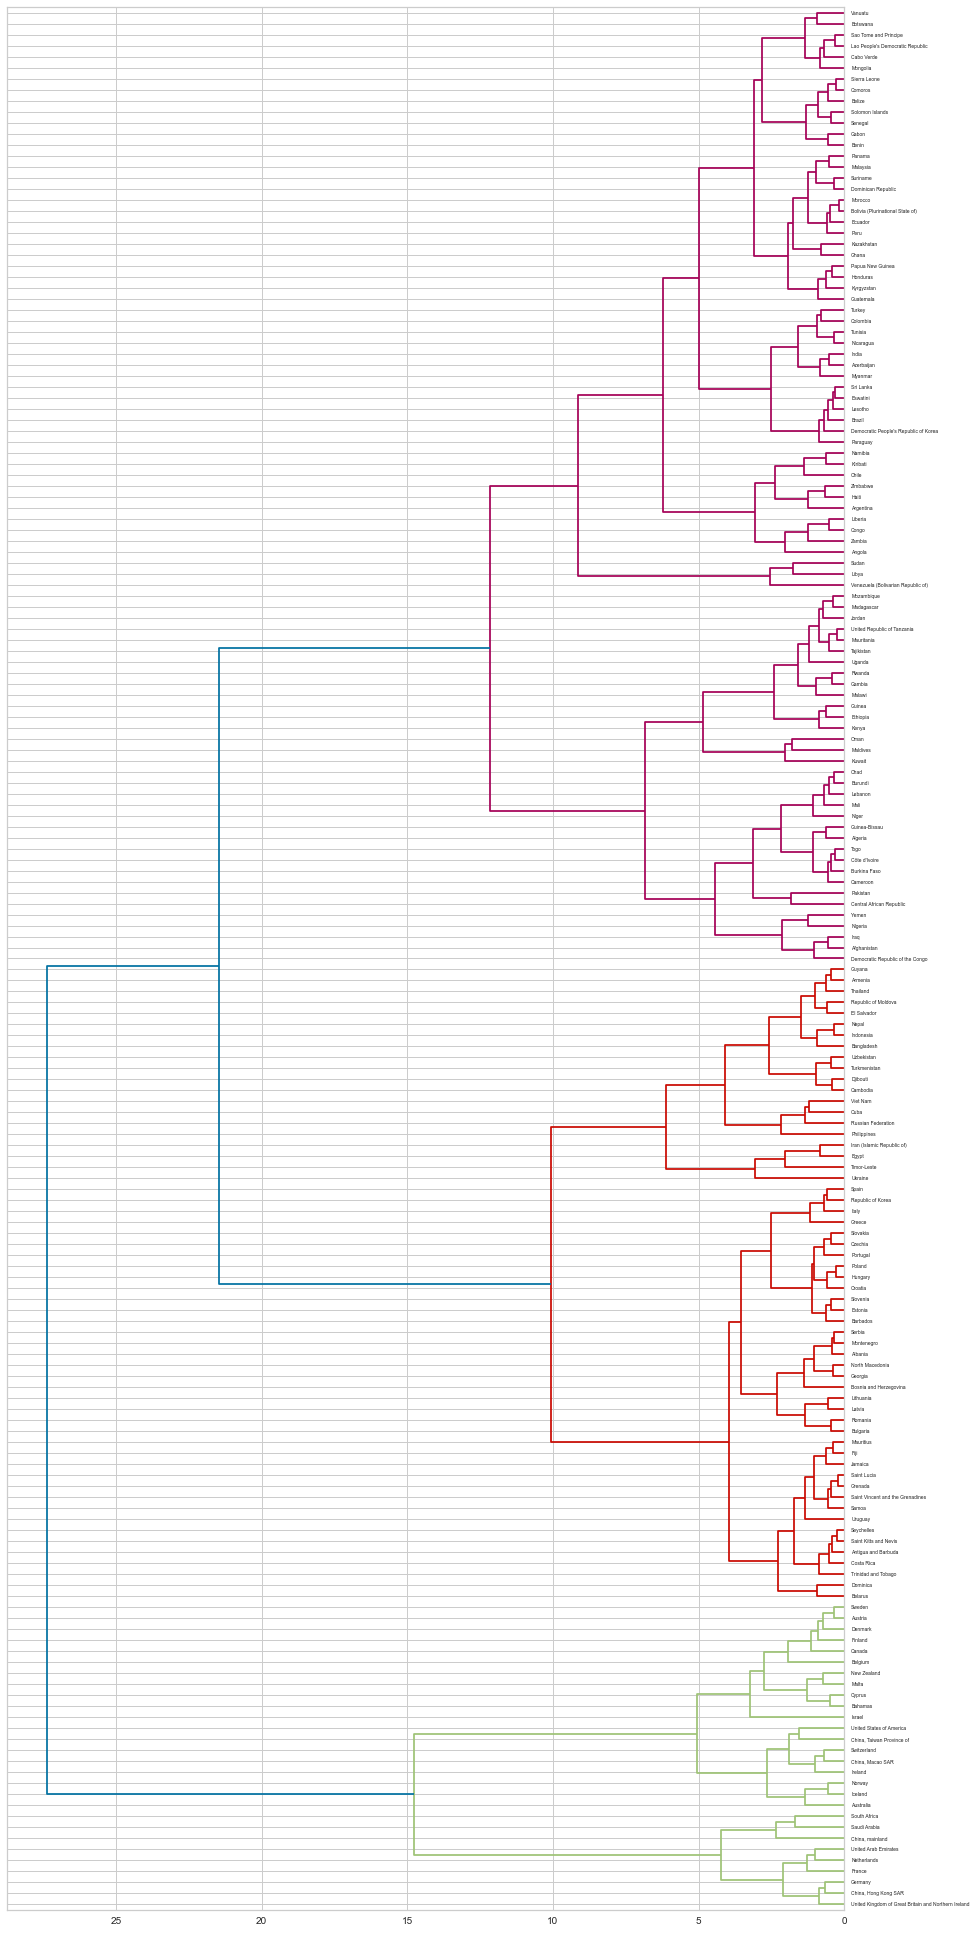

In [24]:
# Show a dendrogram, just for the smallest cluster
from scipy.cluster.hierarchy import linkage, fcluster 
sample = X_clustered
Z = linkage(sample, 'ward') 
names = sample.index
plt.figure(figsize=(15,35))
dendrogram(Z, labels = names, orientation = "left",)
plt.show()

#### 4.2.2. Factorial plane

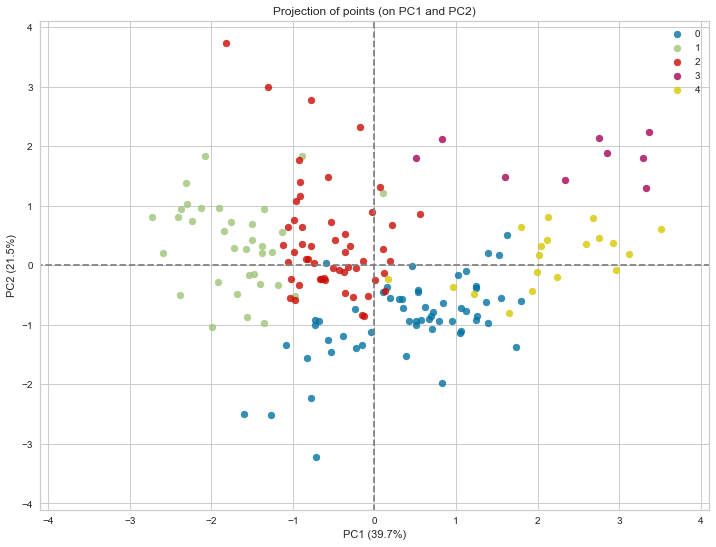

In [25]:
plt.figure(figsize=(12,9))
display_factorial_planes(X_reduced, 2, model_pca, [(0,1)], illustrative_var = clusters, alpha = 0.8)
#X_clustered.boxplot(by="cluster", figsize=(15,10), layout=(2,5))

#### 4.2.3. Analyse des centroïds

,Import Quantity,GDP growth per capita (US$),GDP per capita (US$),Avg. population growth (annual %),Political_Stability
cluster,,,,,
0,-0.168694,0.578939,-0.136326,-0.837347,0.349894
1,-0.319648,0.115227,-0.562919,1.340872,-1.094466
2,-0.252338,-0.593504,-0.492664,0.272165,-0.136150
3,3.833400,-0.234569,1.083560,-0.406976,0.376956
4,-0.024969,-0.206805,2.284489,-0.409763,1.091650


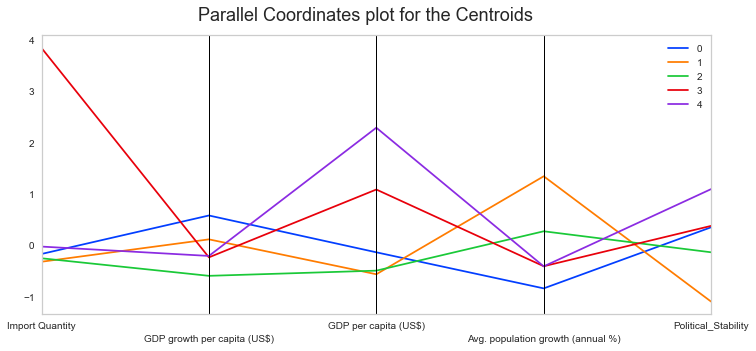

In [26]:
cah_ =  X_clustered.groupby(by="cluster").mean()
display(cah_)
display_parallel_coordinates_centroids(cah_.reset_index(), 5)

<ul>
    <li><strong>Cluster 0 :</strong> représente les pays plutôt stables (moyennement stable) à PIB moyen mais une bonne croissance économique et une faible croissance démographique. Ce cluster et composé de certains pays d'Afrique et d'Asie.</li>
    <li><strong>Cluster 1 :</strong> représente les pays instables à PIB bas avec une croissance économique moyenne et une forte croissance démographique.</li>
    <li><strong>Cluster 2 : </strong> représente les pays moyennement stable limite instable avec un PIB faible et une mauvaise croissance économique.</li>
    <li><strong>Cluster 3 : </strong> représente les plus gros importateurs de volaille, PIB plutot élévé et stabilité politique legerement au dessus de la moyenne .</li>
    <li><strong>Cluster 4 : </strong> représente les pays très stables à PIB élévé.</li>
    </ul>

#### 4.2.4. Composition des clusters

In [27]:
print("="*150,"\n")
print("\033[1m"+"Les {f} pays du cluster 0 :".format(f =len(X_clustered[X_clustered["cluster"]==0]))+"\033[0;0m","\n")
print(X_clustered[X_clustered["cluster"]==0].index.tolist(),"\n")

print("="*150,"\n")
print("\033[1m"+"Les {f} pays du cluster 1 :".format(f =len(X_clustered[X_clustered["cluster"]==1]))+"\033[0;0m","\n")
print(X_clustered[X_clustered["cluster"]==1].index.tolist(),"\n")

print("="*150,"\n")
print("\033[1m"+"Les {f} pays du cluster 2 :".format(f =len(X_clustered[X_clustered["cluster"]==2]))+"\033[0;0m","\n")
print(X_clustered[X_clustered["cluster"]==2].index.tolist(),"\n")

print("="*150,"\n")
print("\033[1m"+"Les {f} pays du cluster 3 :".format(f =len(X_clustered[X_clustered["cluster"]==3]))+"\033[0;0m","\n")
print(X_clustered[X_clustered["cluster"]==3].index.tolist(),"\n")

print("="*150,"\n")
print("\033[1m"+"Les {f} pays du cluster 4 :".format(f =len(X_clustered[X_clustered["cluster"]==4]))+"\033[0;0m","\n")
print(X_clustered[X_clustered["cluster"]==4].index.tolist(),"\n")
print("="*150,"\n")


Les 58 pays du cluster 0 : 

['Albania', 'Antigua and Barbuda', 'Armenia', 'Bangladesh', 'Barbados', 'Belarus', 'Bosnia and Herzegovina', 'Bulgaria', 'Cambodia', 'Costa Rica', 'Croatia', 'Cuba', 'Czechia', 'Djibouti', 'Dominica', 'Egypt', 'El Salvador', 'Estonia', 'Fiji', 'Georgia', 'Greece', 'Grenada', 'Guyana', 'Hungary', 'Indonesia', 'Iran (Islamic Republic of)', 'Italy', 'Jamaica', 'Latvia', 'Lithuania', 'Mauritius', 'Montenegro', 'Nepal', 'North Macedonia', 'Philippines', 'Poland', 'Portugal', 'Republic of Korea', 'Republic of Moldova', 'Romania', 'Russian Federation', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Samoa', 'Serbia', 'Seychelles', 'Slovakia', 'Slovenia', 'Spain', 'Thailand', 'Timor-Leste', 'Trinidad and Tobago', 'Turkmenistan', 'Ukraine', 'Uruguay', 'Uzbekistan', 'Viet Nam'] 


Les 34 pays du cluster 1 : 

['Afghanistan', 'Algeria', 'Burkina Faso', 'Burundi', "Côte d'Ivoire", 'Cameroon', 'Central African Republic', 'Chad', 'Democratic

#### 4.2.5. Conclusions (CAH)

<div>
    <p> Les pays des <strong> clusters 3 et 4 </strong>présentent les meilleurs caractéristiques pour une internationalisation. En effet, ces pays affichent une bonne stabilité politique de manière globale, un pib élévé voire très élévé pour certainset pour finir ce sont les plus gros importateurs de volaille.
     <p> <strong>Le cluster 0 </strong>vient en 3e position Les pays de ce groupe affichent un PIB moyen et une bonne croissance économique. </p>
    <p> <strong>Le cluster 2 </strong> faible PIB et mauvaise croissance économique, à éviter pour le moment. </p>
     <p> <strong>Le cluster 1 </strong> représente des pays instable à faible PIB. Il est à éviter pour le moment </p>
</div>
<br>

<div class="alert-info">
    <p><strong>Important :</strong> prioriser les pays membres de l'UE parmi les clusters 0,3 et 4 afin de bénéfier du marché intérieur et de la libre circulation des marchandises.</p>
</div>
<br>

### 4.3. K-means

In [28]:
model_kmeans = KMeans(n_clusters=5)
model_kmeans.fit(X_scaled)

# Determine which clusters each data point belongs to:
clusters2 =  model_kmeans.fit_predict(X_scaled)

# Add the cluster number to the original scaled data
X_clustered2 = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X_clustered2["cluster"] = clusters2

X_clustered2.head()

,Import Quantity,GDP growth per capita (US$),GDP per capita (US$),Avg. population growth (annual %),Political_Stability,cluster
Area,,,,,,
Afghanistan,-0.222486,0.023886,-0.699567,1.301822,-2.867402,1
Albania,-0.361714,0.220215,-0.448113,-1.268467,0.536455,0
Algeria,-0.500942,-0.627082,-0.519166,0.612440,-0.735913,1
Angola,1.258390,-2.088712,-0.579630,1.786943,-0.224791,1
Antigua and Barbuda,-0.456642,0.576164,0.175795,-0.272693,0.917078,0


In [29]:
# Convert to a data frame
X_reduceddf = pd.DataFrame(X_reduced, index=X.index, columns=['PC1','PC2','PC3','PC4','PC5'])
X_reduceddf['cluster'] = clusters2
X_reduceddf.head()

,PC1,PC2,PC3,PC4,PC5,cluster
Area,,,,,,
Afghanistan,-2.725559,0.814060,0.828476,0.217663,1.277139,1
Albania,0.514577,-0.935686,-0.509240,0.883680,-0.310513,0
Algeria,-1.139527,0.562180,-0.444945,0.033949,0.129079,1
Angola,-0.777855,2.767913,0.120821,-0.360797,-1.055821,1
Antigua and Barbuda,0.566275,-0.913561,-0.319815,-0.389634,-0.278258,0


#### 4.3.1. Factorial Plane

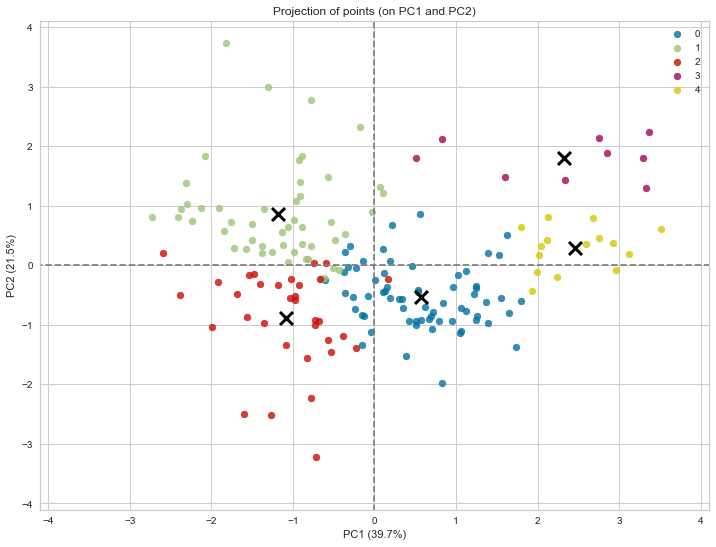

In [30]:
centres_reduced = model_pca.transform(model_kmeans.cluster_centers_)
plt.figure(figsize=(12,9))
display_factorial_planes(X_reduced, 2, model_pca, [(0,1)], illustrative_var = clusters2, alpha = 0.8)
plt.scatter(centres_reduced[:, 0], centres_reduced[:, 1],
            marker='x', s=169, linewidths=3,
            color='black', zorder=10)
plt.show()

#### 4.3.2. Analyse des centroïds

,Import Quantity,GDP growth per capita (US$),GDP per capita (US$),Avg. population growth (annual %),Political_Stability
cluster,,,,,
0,-0.193720,0.076018,-0.079078,-0.752269,0.569904
1,-0.257293,-0.755919,-0.521893,0.916109,-0.706986
2,-0.305141,1.212020,-0.520592,0.428295,-0.726686
3,3.833400,-0.234569,1.083560,-0.406976,0.376956
4,0.081283,-0.340451,2.582752,-0.441776,1.221577


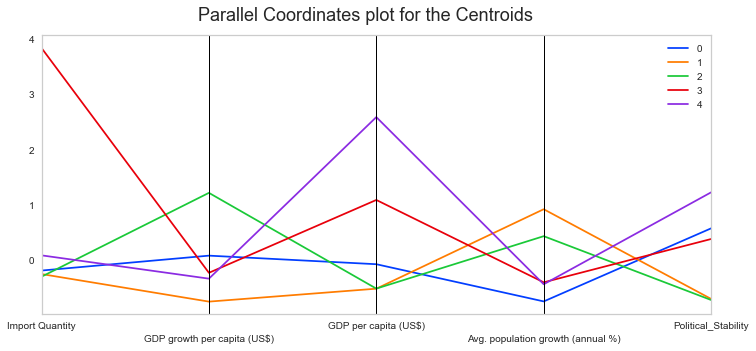

In [31]:
kmeans_ =  X_clustered2.groupby(by="cluster").mean()
display(kmeans_)
display_parallel_coordinates_centroids(kmeans_.reset_index(), 5)

<div class="alert-warning">
    <b>Attention :</b> En fonction de la méthode choisie les clusters présentent des caractéristiques et des tailles légèremment differentes.
</div>
<br>

In [32]:
print("="*150,"\n")
print("\033[1m"+"Les {f} pays du cluster 0 :".format(f =len(X_clustered2[X_clustered2["cluster"]==0]))+"\033[0;0m","\n")
print(X_clustered2[X_clustered2["cluster"]==0].index.tolist(),"\n")

print("="*150,"\n")
print("\033[1m"+"Les {f} pays du cluster 1 :".format(f =len(X_clustered2[X_clustered2["cluster"]==1]))+"\033[0;0m","\n")
print(X_clustered2[X_clustered2["cluster"]==1].index.tolist(),"\n")

print("="*150,"\n")
print("\033[1m"+"Les {f} pays du cluster 2 :".format(f =len(X_clustered2[X_clustered2["cluster"]==2]))+"\033[0;0m","\n")
print(X_clustered2[X_clustered2["cluster"]==2].index.tolist(),"\n")

print("="*150,"\n")
print("\033[1m"+"Les {f} pays du cluster 3 :".format(f =len(X_clustered2[X_clustered2["cluster"]==3]))+"\033[0;0m","\n")
print(X_clustered2[X_clustered2["cluster"]==3].index.tolist(),"\n")

print("="*150,"\n")
print("\033[1m"+"Les {f} pays du cluster 4 :".format(f =len(X_clustered2[X_clustered2["cluster"]==4]))+"\033[0;0m","\n")
print(X_clustered2[X_clustered2["cluster"]==4].index.tolist(),"\n")
print("="*150,"\n")


Les 66 pays du cluster 0 : 

['Albania', 'Antigua and Barbuda', 'Bahamas', 'Barbados', 'Belarus', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria', 'Cabo Verde', 'Chile', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', "Democratic People's Republic of Korea", 'Dominica', 'Dominican Republic', 'El Salvador', 'Estonia', 'Eswatini', 'Fiji', 'Georgia', 'Greece', 'Grenada', 'Guyana', 'Hungary', 'Italy', 'Jamaica', 'Kazakhstan', 'Kiribati', "Lao People's Democratic Republic", 'Latvia', 'Lesotho', 'Lithuania', 'Malaysia', 'Malta', 'Mauritius', 'Mongolia', 'Montenegro', 'Morocco', 'North Macedonia', 'Panama', 'Peru', 'Poland', 'Portugal', 'Republic of Korea', 'Republic of Moldova', 'Romania', 'Russian Federation', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Samoa', 'Sao Tome and Principe', 'Serbia', 'Seychelles', 'Slovakia', 'Slovenia', 'Spain', 'Sri Lanka', 'Suriname', 'Trinidad and Tobago', 'Uruguay', 'Viet Nam'] 


Les 50 pays du cluster 1 :

## 4.4. Comparaison des deux méthodes

In [33]:
cah2 = pd.pivot_table(X_clustered, index="cluster", aggfunc="count").reset_index()
cah2.rename(columns={"Import Quantity":"Nombre_pays (CAH)"}, inplace= True)
kmeans2 = pd.pivot_table(X_clustered2, index="cluster", aggfunc="count").reset_index()
kmeans2.rename(columns={"Import Quantity":"Nombre_pays (Kmeans)"},inplace= True)
pays_x_clusters = cah2[["cluster", "Nombre_pays (CAH)"]].merge(kmeans2[["cluster", "Nombre_pays (Kmeans)"]], on="cluster").set_index("cluster")
pays_x_clusters 

,Nombre_pays (CAH),Nombre_pays (Kmeans)
cluster,,
0,58,66
1,34,50
2,53,33
3,9,9
4,19,15


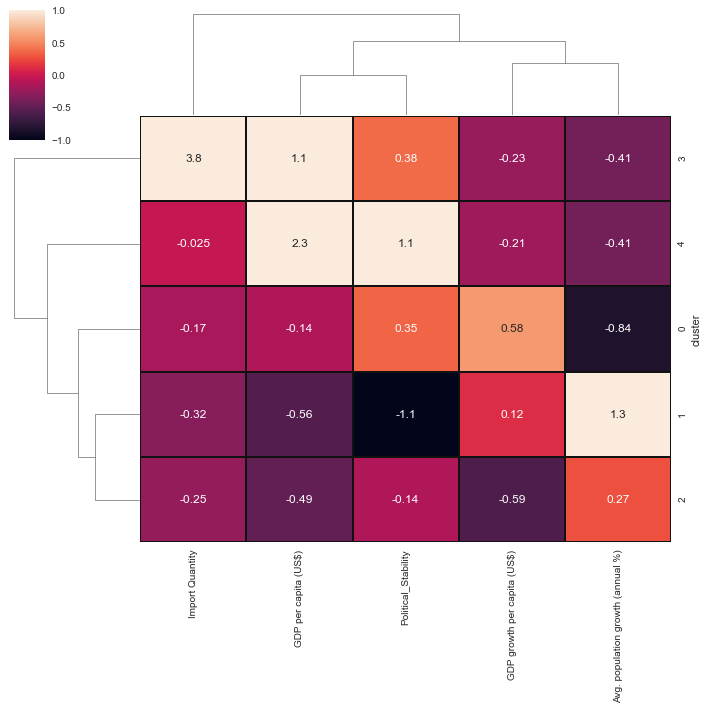

In [34]:
sns.clustermap(cah_, annot=True,linecolor='k', linewidths=2,vmin=-1, vmax=1,)
plt.savefig("cah.png")
plt.show()

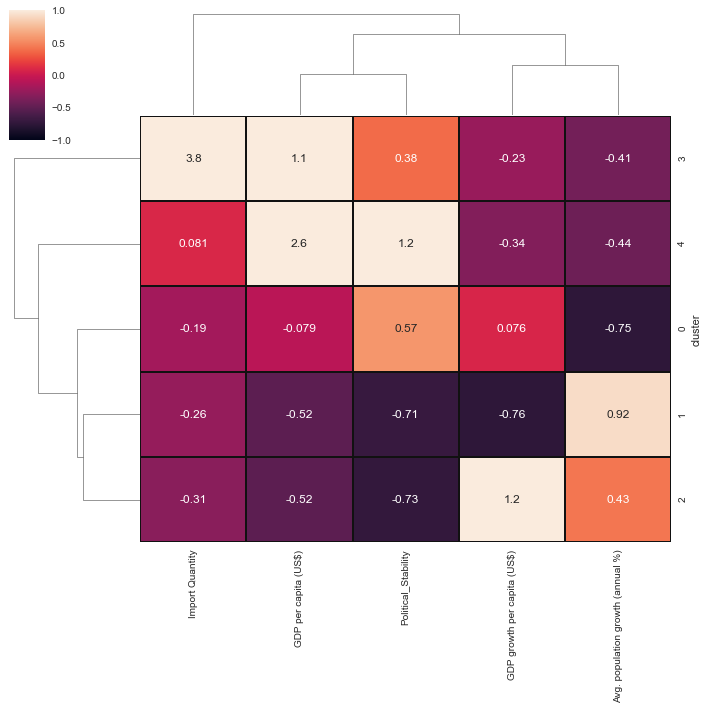

In [35]:
sns.clustermap(kmeans_, annot=True,linecolor='k', linewidths=2,vmin=-1, vmax=1,)
plt.savefig("kmeans.png")
plt.show()


<div class="alert-info">
    <p><strong>  En fonction de la méthode choisie les clusters présentent des caractéristiques et des tailles differentes. </strong></p>
</div>
<br>

## 4.5. Recommandations

Afin de miniser les risques liés à l'internationalisation, nous recommandations pour cettte première phase de tenir comptacp e de la proximité par rapport à la France ainsi que des bénéfices que nous offre le marché intérieur. En d'autres termes de cibler les pays de l'Europe plus particulièrement ceux de l'Union Européenne.

Nous proposons 10 pays de l'Union Européenne parmi les clusters que nous avons recommander suite à la classification.

### Top 10 CAH

In [36]:
data["cluster_CAH"] = clusters
data["cluster_kmeans"] = clusters2
top10_cah = data[data["cluster_CAH"].isin([3,4])][data[data["cluster_CAH"].isin([3,4])]["Region"]=="Europe"].sort_values(by="Union european", ascending=False).head(10).sort_values(by="Import Quantity",ascending=False)
top10_cah

,Import Quantity,GDP growth per capita (US$),GDP per capita (US$),Avg. population growth (annual %),Political_Stability,Region,Union european,cluster_CAH,cluster_kmeans
Area,,,,,,,,,
Germany,831.0,-2.696367,46557.284069,0.48,0.60,Europe,1,3,3
Netherlands,602.0,-0.639925,53236.674668,0.26,0.87,Europe,1,3,3
France,541.0,-2.457160,40516.996615,0.34,0.11,Europe,1,3,3
Belgium,320.0,-1.957791,46388.205209,0.58,0.41,Europe,1,4,4
Denmark,142.0,-2.933837,60216.357595,0.40,0.96,Europe,1,4,4
Austria,113.0,-2.926932,49693.668783,0.77,0.92,Europe,1,4,4
Ireland,95.0,2.302239,81745.514055,0.87,1.03,Europe,1,4,4
Sweden,84.0,-4.504359,53194.436877,0.72,0.91,Europe,1,4,4
Finland,17.0,-2.683228,48585.483016,0.31,0.92,Europe,1,4,4


### Top 10 Kmeans

In [37]:
data["cluster_kmeans"] = clusters2
top10_kmeans = data[data["cluster_kmeans"].isin([2,3])][data[data["cluster_kmeans"].isin([2,3])]["Region"]=="Europe"].sort_values(by="Union european", ascending=False).head(10).sort_values(by="Import Quantity",ascending=False)

top10_kmeans

,Import Quantity,GDP growth per capita (US$),GDP per capita (US$),Avg. population growth (annual %),Political_Stability,Region,Union european,cluster_CAH,cluster_kmeans
Area,,,,,,,,,
Germany,831.0,-2.696367,46557.284069,0.48,0.60,Europe,1,3,3
United Kingdom of Great Britain and Northern Ireland,798.0,-1.333360,42627.966539,0.66,0.05,Europe,0,3,3
Netherlands,602.0,-0.639925,53236.674668,0.26,0.87,Europe,1,3,3
France,541.0,-2.457160,40516.996615,0.34,0.11,Europe,1,3,3
Ukraine,86.0,18.266499,3498.904830,-0.46,-1.83,Europe,0,0,2


## 4.6. Analyse des outliers

In [38]:
out

,Import Quantity,GDP growth per capita (US$),GDP per capita (US$),Avg. population growth (annual %),Political_Stability,Region,Union european
Area,,,,,,,
Japan,1094.0,2.496903,40586.234684,-0.17,1.06,Asia,0
Luxembourg,12.0,-3.364702,114004.238058,2.18,1.37,Europe,1
Mexico,1033.0,2.679234,9946.016618,1.21,-0.57,Americas,0
Syrian Arab Republic,23.0,19.505591,1558.084651,-2.85,-2.74,Asia,0


Le luxembourg est un pays membre de l'UE avec avec un haut PIB. Il est à inserer dans le top pays pour l'internationalisation.

Le Japan présente aussi des caractéristiques très intéressantes. De plus il fait des plus gros importateurs volaille tou comme le Mexique.

La Syrie est trop instable.